<a href="https://colab.research.google.com/github/hwangjunseong/my-first-website/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9Dteam_project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

사용할 라이브러리

In [32]:
#!pip install catboost
!pip install lightgbm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy.linalg as lin
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

데이터 모으기 , 종속변수 벡터와 독립변수 벡터를 분리하기

In [54]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv")



X_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].values
X_test= test.iloc[:,1:].values
y_test=test.iloc[:,0].values

#y_train = np.array(y_train).ravel()#2차원 배열을 1차원 배열로 변경
#y_test = np.array(y_test).ravel()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

pca를 진행하기전에 표준화 보통 [-3,3]에 값이 위치, 또는 정규화[0, 1] 둘 중 하나 선택

In [56]:
X_train.shape
#scaler_minmax=MinMaxScaler()
#X_train = scaler_minmax.fit_transform(X_train)
#X_test = scaler_minmax.transform(X_test)

(60000, 28, 28, 1)

(60032, 784)

In [36]:
#scaler_X = StandardScaler()
#scaler_y = StandardScaler()
#X_train_std = scaler_X.fit_transform(X_train)
#X_test_std = scaler_X.transform(X_test)

In [57]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input  # 이미지 전처리 함수
)

# 증강된 이미지를 훈련 데이터에 추가
augmented_images = datagen.flow(X_train, y_train, batch_size=128, shuffle=False)

# 증강된 이미지를 X_train과 y_train에 추가
X_train_augmented, y_train_augmented = augmented_images.next()
X_train = np.vstack([X_train, X_train_augmented])
y_train = np.hstack([y_train, y_train_augmented])

In [58]:
X_train.shape

(60128, 28, 28, 1)

In [59]:
X_train = X_train.reshape(X_train.shape[0], -1)
print(X_train.shape)

(60128, 784)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,  # 랜덤한 각도로 회전
    width_shift_range=0.2,  # 가로 방향으로 랜덤하게 이동
    height_shift_range=0.2,  # 세로 방향으로 랜덤하게 이동
    shear_range=0.2,  # 전단 변환
    zoom_range=0.2,  # 랜덤한 확대/축소
    horizontal_flip=True,  # 좌우 반전
    preprocessing_function=preprocess_input  # 이미지 전처리 함수
)

# 예시 이미지 로드 및 전처리
img_path = 'path/to/your/image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 이미지 증강 후 시각화
augmented_images = []
for _ in range(5):  # 5장의 증강된 이미지 생성
    augmented_img = datagen.flow(img_array).next()[0]
    augmented_images.append(augmented_img)

# 시각화 코드 (Matplotlib 사용)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# 원본 이미지
axes[0].imshow(img_array[0] / 255.0)
axes[0].set_title('Original')
axes[0].axis('off')

# 증강된 이미지들
for i, augmented_img in enumerate(augmented_images, start=1):
    axes[i].imshow(augmented_img / 255.0)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.show()


In [60]:
#입렦값으로 2차원 배열을 요구한다

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_std = scaler_X.fit_transform(X_train)
X_test_std = scaler_X.transform(X_test)
#y_train = scaler_y.fit_transform(y_train)
#print(np.mean(X_train_std))

PCA

In [61]:

# PCA 모델 생성
pca = PCA(n_components=0.99, svd_solver='auto')
X_train_reduced = pca.fit_transform(X_train_std)
X_test_reduced = pca.transform(X_test_std)
#print(X_train_reduced)

In [6]:
n_components = pca.n_components_
print(f'Number of components: {n_components}')

Number of components: 526


In [11]:
print(len(set(y_train)))

10


In [20]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#lda = LDA(n_components = 9)
#X_train_reduced = lda.fit_transform(X_train_reduced, y_train)
#X_test_reduced = lda.transform(X_test_reduced)

In [ ]:
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components = 784, kernel = 'rbf')
# X_train_reduced = kpca.fit_transform(X_train_reduced)
# X_test_reduced = kpca.transform(X_test_reduced)

In [ ]:
def plot_scree(X, max_dim):
    pca = PCA(n_components=max_dim)
    pca.fit(X)
    eigenvalues = pca.explained_variance_
    plt.plot(np.arange(1, max_dim+1), eigenvalues, 'o-', linewidth=2)
    plt.xlabel('Number of components')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')
    plt.show()

In [ ]:
#plot_scree(X_train_reduced, 0.95)

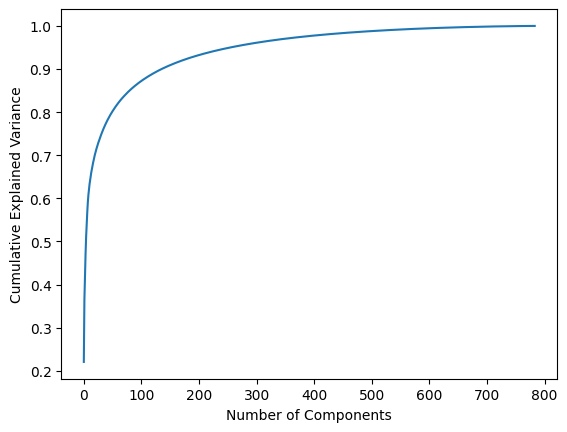

In [ ]:

# 데이터를 X에 로드하고 정규화 등의 전처리 수행

# PCA 모델 생성
pca = PCA()
pca.fit(X_train_std)

# 누적 설명 분산량 확인
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# 그래프로 시각화
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
#xgb:accuracy : 87.39 %
#표준편차:  0.25 %
#SVM: accuracy : 87.54 %
#표준편차:  0.29 %
#lgb:accuracy : 87.05 %
#표준편차:  0.26 %
#hist:accuracy : 87.03 %
#표준편차:  0.25 %
#randomforest: accuracy : 86.50 %
#표준편차:  0.30 %

모델 선택 => k폴더 교차검증,그리디 서치=> 최적의 parameter찾기,  앙상블


In [ ]:
svm_model = SVC(kernel = 'rbf', probability = True,gamma = 'auto', random_state = 42)
classifier_xgb = XGBClassifier( random_state = 42)
# lgb_model = lgb.LGBMClassifier( random_state = 42)
# hist_gb_model = HistGradientBoostingClassifier(max_iter=100, random_state=42)
# rf_model = RandomForestClassifier( random_state=42)
# catboost_model = CatBoostClassifier(random_state = 42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score


# 정밀도를 사용하는 custom_scorer 생성
precision_scorer = make_scorer(precision_score, average='micro')  # 'micro', 'macro', 'weighted' 등의 옵션도 사용 가능

# 교차 검증 수행
precisions = cross_val_score(estimator=svm_model, X=X_train_reduced, y=y_train, cv=10, scoring=precision_scorer)

# 정밀도 출력
print("Precision: {:.2f} %".format(precisions.mean() * 100))
print("표준편차: {:.2f} %".format(precisions.std() * 100))

In [ ]:
print("Precision: {:.2f} %".format(precisions.mean() * 100))
print("표준편차: {:.2f} %".format(precisions.std() * 100))

NameError: ignored

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_xgb, X = X_train_reduced, y = y_train, cv = 10)
print("accuracy : {:.2f} %".format(accuracies.mean()*100))
print("표준편차: {: .2f} %".format(accuracies.std()*100))

accuracy : 88.44 %
표준편차:  0.32 %


In [22]:
model=SVC(kernel = 'rbf', gamma = "auto", C=35, probability = True, random_state = 42) #0.99, C =35
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 0.9994833333333333
평가 데이터 : 0.9073


In [30]:
model = XGBClassifier( n_estimators= 700, gamma = 0.1, max_depth = 10,reg_lambda= 1, random_state = 42)
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 1.0
평가 데이터 : 0.8764


In [ ]:
model=SVC(kernel = 'rbf', gamma = "auto", C=40, probability = True, random_state = 42) #0.99, C =40
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 0.9997333333333334
평가 데이터 : 0.9078


In [62]:
model=SVC(kernel = 'rbf', gamma = "auto", C=40, probability = True, random_state = 42) #0.99, C =40, 데이터증강
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 0.9979377328366152
평가 데이터 : 0.9078


In [ ]:
model=SVC(kernel = 'rbf', gamma = "auto", C=100, probability = True, random_state = 42) #0.99, C=100
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 1.0
평가 데이터 : 0.9075


In [ ]:
model=SVC(kernel = 'rbf', gamma = "auto", C=40, probability = True, random_state = 42) #n_component 783 , MAP ->0.82
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 0.9982
평가 데이터 : 0.9049


In [ ]:
model=SVC(kernel = 'rbf', gamma = "auto", C=30, probability = True, random_state = 42) #0.95
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 0.9999
평가 데이터 : 0.9008


In [ ]:
model=SVC(kernel = 'rbf', gamma = "auto", C=40, probability = True, random_state = 42) #700
model.fit(X_train_reduced, y_train)

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 0.99885
평가 데이터 : 0.9055


In [ ]:
# param_grid = {

#     'criterion': ['gini', 'entropy']  # 분할 품질을 측정하는 기준
# }
# grid_search=GridSearchCV(RandomForestClassifier(), param_grid, cv=10, return_train_score=True)
# grid_search.fit(X_train_reduced,y_train) #여기서 y_train이 1차원 배열이여야함
# rf = grid_search.best_params_
# print("Best Parameter: {}".format(grid_search.best_params_))
# print("Best Cross-validity Score: {:.3f}".format(grid_search.best_score_))

Best Parameter: {'criterion': 'entropy'}
Best Cross-validity Score: 0.504


In [ ]:
#parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']}, #C가 낮을수록 정규화가 강해진다
#              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}] #gamma는 커널의 공식 계수 -> gamma커널은 rbf에만 적용가능 linear에는 불가능
parameter_grid = {
    'gamma': [0.1, 0.9]
}

#svm_model = SVC(kernel = 'rbf', probability = True)
grid_search = GridSearchCV(estimator = SVC(kernel = 'rbf', probability = True),
                           param_grid = parameter_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1) # n_jobs : 머신에서 모든 프로세서가 사용된다

grid_search.fit(X_train_reduced, y_train)
svr = grid_search.best_params_
print(" {}".format(svr['gamma']))
print("Best Parameter: {}".format(grid_search.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_search.best_score_))

In [ ]:
#'max_iter': 100
#{'max_depth': 3}
#{'learning_rate': 0.01}
#{'max_leaf_nodes': 15}

In [ ]:
parameter_grid = {
    'learning_rate': [0.01, 0.05, 0.1],

}

hist_gb_model = HistGradientBoostingClassifier(random_state=42)
grid_search=GridSearchCV(hist_gb_model, parameter_grid, cv=10, return_train_score=True)
grid_search.fit(X_train_reduced, y_train)
hgm = grid_search.best_params_
# 데이터 평가
print("Best Parameter: {}".format(grid_search.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_search.best_score_))

In [ ]:



# 모델
#classfier_cb = CatBoostClassifier(custom_metric = 'MultiClass')
#grid_search=GridSearchCV(classfier_cb, parameter_grid, cv=10, return_train_score=True)
#grid_search.fit(X_train_reduced, y_train)
#cbc = grid_search.best_params_
# 데이터 평가
#print("Best Parameter: {}".format(grid_search.best_params_))
#print("Best Cross-validity Score: {:.3f}".format(grid_search.best_score_))

In [ ]:
parameter_grid = {
   'gamma': [0.1, 0.2],

}

xgb_model = XGBClassifier()


grid_search_xgb=GridSearchCV(xgb_model, parameter_grid, cv=10, return_train_score=True)
grid_search_xgb.fit(X_train_reduced, y_train)
xm = grid_search_xgb.best_params_
best_model = grid_search.best_estimator_.clone()
print(" {}".format(xm['gamma']))
# 데이터 평가
print("Best Parameter: {}".format(grid_search_xgb.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_search_xgb.best_score_))

 0.1


AttributeError: ignored

In [ ]:
#Best Parameter: {'gamma': 0.1}
Best Cross-validity Score: 0.884
print("Best Parameter: {}".format(grid_search_xgb.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_search_xgb.best_score_))

Best Parameter: {'gamma': 0.1}
Best Cross-validity Score: 0.884


In [ ]:
 #'max_depth': [3, 5, 7],  # 트리의 최대 깊이
 #   'num_leaves': [15, 31, 63],  # 리프 노드 수
 #   'subsample': [0.8, 1.0],  # 데이터 샘플링 비율
 #   'colsample_bytree': [0.8, 1.0],  # 트리마다 사용할 특성의 비율
 #   'reg_alpha': [0.0, 0.1, 0.5],  # L1 정규화 강도
 #   'reg_lambda': [0.0, 0.1, 0.5],  # L2 정규화 강도
 #   'min_child_samples': [5, 10, 20],

In [ ]:
parameter_grid = {
    'n_estimators': [50, 100, 200],

}
lgb_model = lgb.LGBMClassifier()
#{'n_estimators': 200
grid_search=GridSearchCV(lgb_model, parameter_grid, cv=10, return_train_score=True)
grid_search.fit(X_train_reduced, y_train)
lm = grid_search.best_params_
# 데이터 평가
print("Best Parameter: {}".format(grid_search.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_search.best_score_))

In [6]:
#svm_model = SVC(kernel = 'rbf', probability = True, C= svr['C'], random_state = 42)

svm_model = SVC(kernel = 'rbf', probability = True, gamma = "auto", C= 40, random_state = 42)
classifier_xgb = XGBClassifier( n_estimators= 300, gamma = 0, random_state = 42)

#rf_model = RandomForestClassifier( random_state=42)
lgb_model = lgb.LGBMClassifier(n_estimators = 300, random_state = 42)
hist_gb_model = HistGradientBoostingClassifier(max_iter=100, random_state=42)

#cat_model = CatBoostClassifier(iterations=100,  # 반복 횟수
 #                          learning_rate=0.05,  # 학습률
  #                         depth=10,  # 트리 깊이
   #                        loss_function='MultiClass',  # 다중 클래스 분류용 손실 함수
    #                       custom_metric='Accuracy')


#lgb_model = lgb.LGBMClassifier(n_estimators = lm['n_estimators'], random_state = 42)
#hist_gb_model = HistGradientBoostingClassifier(learning_rate = hgm['learning_rate'],max_iter=100, random_state=42)
rf_model = RandomForestClassifier(criterion = "entropy", random_state=42)

#model = VotingClassifier(
#    estimators=[ ('rf', rf_model),('hist_gb', hist_gb_model),('lm', lgb_model), ('cx', classifier_xgb), ('svc', svm_model)], voting='soft')

model = VotingClassifier(
    estimators=[  ('lm', lgb_model), ('cx', classifier_xgb), ('rm', rf_model),('svc', svm_model)], voting='soft')
model.fit(X_train_reduced, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.831375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134130
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 526
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

VotingClassifier(estimators=[('lm',
                              LGBMClassifier(n_estimators=300,
                                             random_state=42)),
                             ('cx',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importanc...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rm',
                              RandomForestClassifier(criterion='entropy',
                                                     random_state=42)),
                             ('svc',
                              SVC(C=40, gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [ ]:

print('학습 데이터 : {}'.format(model.score(X_train_reduced,y_train)))
print('평가 데이터 : {}'.format(model.score(X_test_reduced,y_test)))

학습 데이터 : 1.0
평가 데이터 : 0.9041


test데이터로 예측

In [63]:
#np.array(X_test_reduced).ravel()

y_pred = (model.predict(X_test_reduced))
print(X_test_reduced)
print(y_pred)

[[ 1.59826020e+01 -4.72258022e+00 -1.08819185e+00 ...  8.69550846e-02
   1.47859120e-01 -9.58604254e-02]
 [-1.40822995e+00 -1.72238722e+01 -6.27680491e+00 ...  2.47386184e-02
   1.23788887e-01 -2.01322211e-01]
 [-9.75952306e+00 -3.22613999e+00  1.14783321e+01 ...  1.64919959e-01
   2.58162633e-01 -5.96068572e-02]
 ...
 [ 4.65583278e+00  1.00161810e+01  4.88728097e+00 ... -1.04872363e-01
  -4.22090055e-02 -2.42585688e-01]
 [ 2.01063053e+01  1.76115952e+01  5.10407929e-01 ... -6.89300590e-01
  -2.12419454e-01  1.75605851e-01]
 [ 2.26557013e+01 -1.65154800e+00  4.54171604e+00 ... -6.32310500e-02
   2.10055503e-02 -2.21079998e-01]]
[0 1 2 ... 8 8 1]


In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
#TN FP            TP          TP
#FN TP 정밀도는 TP+FP 재헌율 TP+FN
accuracy_score(y_test, y_pred)

[[860   0  13  16   1   0  95   0  15   0]
 [  4 987   1   7   0   0   0   0   1   0]
 [ 14   1 852  12  62   0  52   0   7   0]
 [ 24  12   9 920  22   0  12   0   1   0]
 [  4   1  58  22 877   0  36   0   2   0]
 [  0   0   0   0   0 952   1  27   9  11]
 [117   1  55  27  50   0 732   0  18   0]
 [  0   0   0   0   0   7   0 956   0  37]
 [  1   0   4   2   1   1   4   2 985   0]
 [  0   0   0   0   0   4   0  31   8 957]]


0.9078

In [65]:
from sklearn.metrics import f1_score
# 다중 클래스에 대한 F1 점수 계산
#클래스 불균형이 심한 경우 F1 점수가 떨어질 수 있습니다.
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 간의 샘플 수로 가중평균을 계산함
#micro", "macro", "weighted", "samples"
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9073


In [66]:
from sklearn.metrics import classification_report

# classification_report를 사용하여 클래스별 정밀도, 재현율, F1 점수 출력
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.85      0.86      1000
           3       0.91      0.92      0.92      1000
           4       0.87      0.88      0.87      1000
           5       0.99      0.95      0.97      1000
           6       0.79      0.73      0.76      1000
           7       0.94      0.96      0.95      1000
           8       0.94      0.98      0.96      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



혼동행렬 사용하여 정확도 예측

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
#TN FP            TP          TP
#FN TP 정밀도는 TP+FP 재헌율 TP+FN
accuracy_score(y_test, y_pred)

[[865   0  13  17   1   1  88   0  15   0]
 [  3 986   1   8   0   0   1   0   1   0]
 [ 15   1 853  13  61   0  50   0   7   0]
 [ 27  12  11 916  21   0  12   0   1   0]
 [  4   1  59  25 873   0  36   0   2   0]
 [  0   0   0   0   0 951   1  27  10  11]
 [116   1  59  28  45   0 733   0  18   0]
 [  0   0   0   0   0   7   0 956   0  37]
 [  2   0   4   2   1   1   3   2 985   0]
 [  0   0   0   0   0   4   0  31   8 957]]


0.9075

In [ ]:
from sklearn.metrics import precision_score, recall_score



# 로지스틱 회귀 모델 학습
#model = LogisticRegression()
model = SVC(kernel = 'rbf', probability = True,gamma = 'auto', random_state = 42)
classifier_xgb = XGBClassifier( random_state = 42)
model.fit(X_train_reduced, y_train)
# 테스트 데이터에 대한 확률값 예측
probabilities = model.predict_proba(X_test_reduced)[:, 1]  # 양성 클래스에 대한 확률값 선택

# 임계값 조절
threshold = 0.5  # 예시로 0.5를 기준으로 설정
predictions = (probabilities >= threshold).astype(int)

# 정밀도와 재현율 계산
precision = precision_score(y_test, predictions,average='micro')
recall = recall_score(y_test, predictions,average='micro')

print(f'정밀도: {precision}')
print(f'재현율: {recall}')

# 곡선 시각화
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

ValueError: ignored

예측된 클래스 값을 testResult.txt 파일에 저장

In [67]:

with open("testResult.txt", "w") as f:
    for index, prediction in enumerate(y_pred):
      index_str = f"{index:05d}" #5자리의 길이로 표시하고, 빈 자리는 0으로 채우는 문자열을 생성
      result = f"{index_str} {int(prediction)}"
      f.write(result + "\n")


In [68]:
with open("testResult.txt", "r") as f:
    content = f.read()

#print(content)

In [69]:
import sys
import numpy as np
from sklearn.metrics import auc
from collections import Counter

testResult_path = sys.argv[1]
label_path = sys.argv[2]

# pred에 해당하는 testResult.txt 파일 읽어오는 부분입니다.
with open("testResult.txt", "r") as f:
    preds = f.readlines()

# 정답에 해당하는 label.txt 파일 읽어오는 부분입니다.
with open("/content/drive/MyDrive/Colab Notebooks/label.txt", 'r') as file2:
    labels = file2.readlines()


# pred와 label의 클래스값만 리스트로 변환하는 부분입니다.
p = np.array([pred.strip().split()[1] for pred in preds])
l = np.array([label.strip().split()[1] for label in labels])

# pred의 클래스 개수를 count하는 부분입니다.
predict_label_count_dict = Counter(p)
predict_label_count_dict = dict(sorted(predict_label_count_dict.items()))

## mAP 계산하는 부분입니다.
AP = []
num_class = 10

# 모든 클래스에 대해 반복
for c, freq in predict_label_count_dict.items() :
    TP = 0
    FN = 0

    temp_precision = []
    temp_recall = []

    for i in range(len(p)):
        # TP, FN 계산
        if l[i] == c and p[i] == c :
            TP += 1
        elif l[i] != c and p[i] == c :
            FN += 1

        # preciison, recall 계산
        if TP+FN != 0:
            temp_precision.append(TP/(TP+FN))
            temp_recall.append(TP/freq)

    # AP 배열에 클래스 각각의 AP value 저장
    # auc : preciison-recall curve의 면적 구해줌
    AP.append(auc(temp_recall, temp_precision))

mAP = sum(AP) / num_class

# 각각의 클래스에 대한 AP와 mAP의 Table 출력 부분입니다.
class_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
table = "| {:<13} | {:<13} |\n".format("Class", "AP") + "|---------------|---------------|\n"

for c_name, ap in zip(class_name, AP):
    table += "| {:<13} | {:<13.2f} |\n".format(c_name, ap)

table += "| {:<13} | {:<13.2f} |\n".format("mAP", mAP)

print(table)

| Class         | AP            |
|---------------|---------------|
| T-shirt/top   | 0.69          |
| Trouser       | 0.97          |
| Pullover      | 0.74          |
| Dress         | 0.84          |
| Coat          | 0.74          |
| Sandal        | 0.97          |
| Shirt         | 0.62          |
| Sneaker       | 0.88          |
| Bag           | 0.89          |
| Ankle boot    | 0.91          |
| mAP           | 0.82          |



In [27]:


#현재 각 클래스에 대한 불균형은 없는 상태이다 각 클래스 6천개씩 되어있음

In [ ]:

from sklearn.metrics import precision_score, recall_score



# 로지스틱 회귀 모델 학습
#model = LogisticRegression()
model = SVC(kernel = 'rbf', probability = True,gamma = 'auto', random_state = 42)
classifier_xgb = XGBClassifier( random_state = 42)
model.fit(X_train_reduced, y_train)
# 테스트 데이터에 대한 확률값 예측
probabilities = model.predict_proba(X_test_reduced)[:, 1]  # 양성 클래스에 대한 확률값 선택

# 임계값 조절
threshold = 0.5  # 예시로 0.5를 기준으로 설정
predictions = (probabilities >= threshold).astype(int)

# 정밀도와 재현율 계산
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f'정밀도: {precision}')
print(f'재현율: {recall}')

# 곡선 시각화
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()